In [2]:
import sys
import math
from scipy import integrate, optimize
import numpy as np 
from matplotlib import pyplot
%matplotlib inline

from os.path import expanduser


In [4]:
E0 = 2. # E0 set as constant if not being fit 

def dNdE_powerlaw(E, Ethresh, N0, A): # energy (TeV), E0, norm, index
    if Ethresh <= 0 or N0 <= 0 or A <= 0: # these quantities must be positive 
        return sys.float_info.max
    dNdE = N0*np.power(E/Ethresh,-A)
    return dNdE

def dNdE_cutoff(E, Ecut, N0, A): # cutoff energy (TeV)
    if Ecut <= 3 or Ecut >= 50 or N0 <= 0 or A <= 0: # E <= 0 does not work because it is an array
        return sys.float_info.max
    dNdE = N0*(E/E0)**(-A)*np.exp(-E/Ecut)
    return dNdE

def dNdE_broken(E, Ebreak, N0, A, A2): # break energy (TeV), break index 
    if Ebreak <= 0 or N0 <= 0 or A <= 0 or A2 <= 0:
        return sys.float_info.max
    dNdE = N0*(E/E0)**(-A)*1/(1+(E/Ebreak)**(A2-A))
    return dNdE


$$\frac{dN}{dE}=N_0\times\left(\frac{E}{E_0}\right)^{-\alpha}$$

$$\frac{dN}{dE}=N_0\times\left(\frac{E}{E_0}\right)^{-\alpha}\times e^{-\frac{E}{E_{cut}}}$$

$$\frac{dN}{dE}=N_0\times\left(\frac{E}{E_0}\right)^{-\alpha}\times \frac{1}{1+\left(\frac{E}{E_{break}}\right)^{\gamma-\alpha}}$$


To Do: compare Crab run with the same elevation range 

<h1>Spectra fitting 

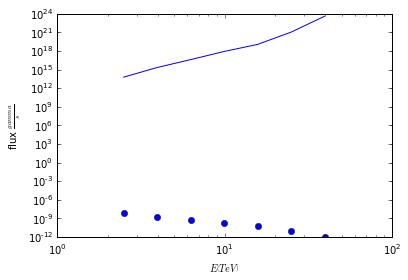

In [5]:
home = expanduser("~")
gc_dir = home + "/Dropbox/GalacticCenter/"

data = np.genfromtxt(gc_dir+"/spectralPoints/SgrA_4tels_noPoor_dNdE_TeV.txt")

E_array = np.array(data[:,0], dtype=np.float64)
flux_obs_array = np.array(data[:,1], dtype=np.float64)
#flux_err_array = np.array(data[:2], dtype=np.float64)
    
logE = list(map(lambda l: math.log10(l), E_array))
logF = list(map(lambda l: math.log10(l), flux_obs_array))

flux_powlaw = dNdE_powerlaw(flux_obs_array, 1.0, 6.113e-8, 2.57)

pyplot.plot(E_array, flux_obs_array, 'bo') 
pyplot.plot(E_array, flux_powlaw)
pyplot.xlabel(r"$E\left(TeV\right)$")
pyplot.ylabel(r"flux $\frac{gamma}{s}$") # gamma / m^2*s*TeV
pyplot.xscale('log')
pyplot.yscale('log')
#pyplot.xlim(1.5e0, 5.e1)
#pyplot.ylim(1.e-13, 1.e-7)



In [ ]:
powlaw_guess = (1., 1e-9, 2.5)
powlaw_bounds = ((0.5,20.), (1.e-7,1.e-11), (1.5,4.5))
p_opt_powlaw, p_cov_powlaw = optimize.curve_fit(dNdE_powerlaw, E_array, flux_obs_array, p0=powlaw_guess)

print(tuple(p_opt_powlaw))

#res = optimize.minimize(err, powlaw_guess )#bounds=powlaw_bounds)


In [ ]:
cutoff_guess = (15, 1e-9, 2.5)
p_opt_cutoff, p_cov_cutoff = optimize.curve_fit(dNdE_cutoff, E_array, flux_obs_array, p0=cutoff_guess, maxfev=2500)
print(p_opt_cutoff)


In [ ]:
broken_guess = (15, 1e-9, 2.5, 2.)
p_opt_broken, p_cov_broken = optimize.curve_fit(dNdE_broken, E_array, flux_obs_array, p0=broken_guess, maxfev=2500)
print(p_opt_broken)

In [ ]:
flux_array_fit = dNdE_powerlaw(E_array, *p_opt_powlaw)

pyplot.plot(E_array, flux_obs_array, 'bo') # star because it is a map 
pyplot.plot(E_array, flux_array_fit)
#pyplot.plot(E_array, )
pyplot.xlabel(r"$E\left(TeV\right)$")
pyplot.ylabel(r"flux $\frac{gamma}{s}$") # gamma / m^2*s*TeV
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.xlim(1.5e0, 5.e1)
pyplot.ylim(1.e-13, 1.e-7)



The above fit is not weighted by statistics of each point

<h2>Integral Flux

In [ ]:
# set the fit parameters for each source 
norm_SgrA = 6.113e-8
index_SgrA = 2.57
norm_Crab = 3.157e-7 
index_Crab = 2.525 

Edec = 7 # estimate of decorrelation energy in TeV

Emin_Crab = 0.5 # TeV 
Emin_SgrA = 2.0 # TeV
Emax_both = 40. # TeV

gamma_rate_SgrA = 0.155 # gamma / min 
gamma_rate_Crab = 2.63  # gamma / min

In [ ]:
# integrate the differential energy distribution for Sgr A* 
int_tuple_SgrA = integrate.quad(dNdE_powerlaw, Emin_SgrA, math.inf, args=(Edec, norm_SgrA, index_SgrA))
int_flux_SgrA = int_tuple_SgrA[0]
int_upperBoundErr_SgrA = int_tuple_SgrA[1]

# now for the Crab with the same bounds as for Sgr A*
int_tuple_Crab_1 = integrate.quad(dNdE_powerlaw, Emin_SgrA, math.inf, args=(Edec, norm_Crab, index_Crab))
int_flux_Crab_1 = int_tuple_Crab_1[0]
int_upperBoundErr_Crab_1 = int_tuple_Crab_1[1]

# do the Crab with its full, larger energy range
int_tuple_Crab_2 = integrate.quad(dNdE_powerlaw, Emin_Crab, math.inf, args=(Edec, norm_Crab, index_Crab))
int_flux_Crab_2 = int_tuple_Crab_2[0]
int_upperBoundErr_Crab_2 = int_tuple_Crab_2[1]

print(int_flux_SgrA)
print(int_flux_Crab_1)
print(int_flux_Crab_2)

In [ ]:
print("The ratio of Sgr A* flux to the Crab flux, integrated from 2TeV to 40TeV for both:")
print(int_flux_SgrA/int_flux_Crab_1)

print("The ratio of Sgr A* flux to the Crab flux, integrated from 0.5TeV to 40TeV for Crab")
print(int_flux_SgrA/int_flux_Crab_2)

print("The ratio of Sgr A* gamma rate to Crab gamma rate, as reported by VEGAS")
print(gamma_rate_SgrA/gamma_rate_Crab)

<table border="1">
<tr>
<th>Source</th>
<th>Flux from 2TeV to Infiniti</th>
</tr>
<tr>
<td>Sgr A*</td>
<td>$$1.393\times10^{-10}$$</td>
</tr>
<tr>
<td>Crab</td>
<td>$$8.01\times10^{-10}$$</td>
</tr>
<tr>
<td>Ratio</td>
<td>$$0.1739$$</td>
</tr>
</table>

$$Flux_{SgrA}={{a}}\frac{gamma}{{m^2s}}$$

<h3> Misc Code

In [ ]:
err = lambda p: np.mean((powerlaw(E_array, *p)-F_array)**2)

In [ ]:
def powerlaw(E, *params): # energy (TeV), E0, norm, index
    E0, N0, A = params
    dNdE = N0*np.power(E/E0,-A)
    return dNdE

In [ ]:
xarray = []
for i in x:
    xarray.append(i)

logE = []
for i, v in enumerate(E_array):
    logE.append(math.log10(v))
    
logF = []
for i, v in enumerate(F_array):
    logF.append(math.log10(v))

par = (5, 5)
print(type(par))
brack = [5, 5]
print(type(brack))

optimize.minimize?